Exercises 

1. Run the lab instruction. For the dataset part, split randomly to the data into 90% of train 
set and 10% of test set. (30 points)

3. Create InceptionResNet. Notice that 1 inception block is similar to one ResNet Module. 
You can use the pattern of InceptionNet from previous Lab. Train the model using 
CIFAR10 dataset, plot graphs on the outputs. (40 points)


5. Find your own dataset which contains at least 3 classes. If you download from 
somewhere, please reference in your report. Make your own dataset class, explain how to 
setup your data and the label. Train the dataset in ResNet and InceptionResNet, show 
your results. (30 points)


Turn-in report 

Export the output of the lab in PDF. You can do in the same file or create separate files of your 
homework and in-class exercise. Submit in PDF file and Jupyter notebook. 
You don't need to upload dataset.

Solution 

1. Run the lab instruction. For the dataset part, split randomly to the data into 90% of train 
set and 10% of test set. (30 points)

Python Code for Vege Dataset split into 90% train set and 10% test set



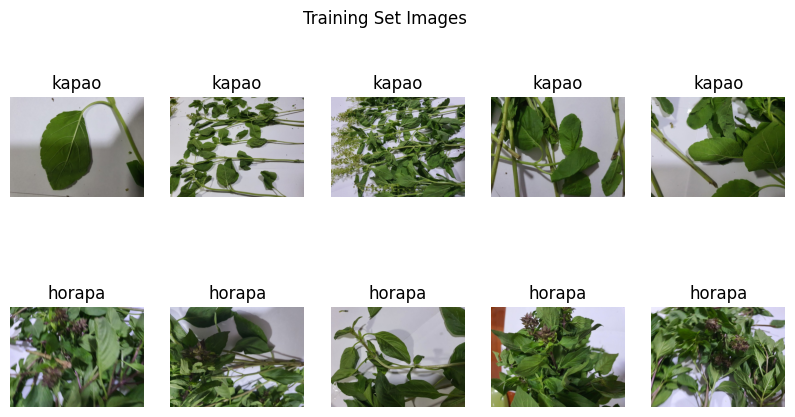

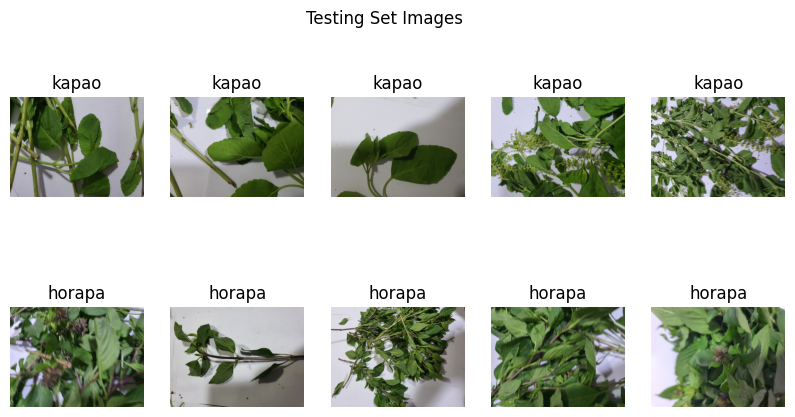

Images have been split into training and testing sets,and displayed.


In [14]:
import os
import random
import shutil
import matplotlib.pyplot as plt
from PIL import Image

#Set the paths
root_dir = r'/home/jupyter-125993/Lab05/vege_dataset'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

#Create training and testing directories if they do not exist.
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Define the class names
class_names = ['kapao', 'horapa']

#Function to split images into training and testing sets
def split_images():
    for class_name in class_names:
        class_path = os.path.join(root_dir, class_name)
        # Get all items in the directory
        all_items = os.listdir(class_path)
        # Filter the list to include ONLY files and ignore directories
        images = [item for item in all_items if os.path.isfile(os.path.join(class_path, item))]

        #shuffle the images
        random.shuffle(images)

        #Calculate the number of training and testing images
        train_size = int(0.9*len(images))

        #Split the images
        train_images = images[:train_size]
        test_images = images[train_size:]

        #Create class directories in train and test directories
        os.makedirs(os.path.join(train_dir, class_name),exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name),exist_ok=True)
        
        #Move images to train directory
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir,class_name, img))
                        
        #Move images to test directory
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name,img))

#Function to display a few images from a given directory
def display_images(data_dir, title):
    plt.figure(figsize=(10,5))
    for i, class_name in enumerate(class_names):
        class_path= os.path.join(data_dir, class_name)
        images= os.listdir(class_path)[:5] #Display first 5 images from each class
        for img in images:
            img_path = os.path.join(class_path, img)
            image= Image.open(img_path)
            plt.subplot(len(class_names), 5, i*5+ images.index(img)+1)
            plt.imshow(image)
            plt.axis('off')
            plt.title(class_name)
    plt.suptitle(title)
    plt.show()
#Split images into training and testing sets
split_images()

#Display training images
display_images(train_dir, "Training Set Images")

#Display testing images
display_images(test_dir, "Testing Set Images")

print("Images have been split into training and testing sets,and displayed.")



2. Create InceptionResNet. Notice that 1 inception block is similar to one ResNet Module. 
You can use the pattern of InceptionNet from previous Lab. Train the model using 
CIFAR10 dataset, plot graphs on the outputs. (40 points) 

In [1]:
#Importing Libraries
import torch
import torch.nn as nn   
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


#Step1: Define the InceptionResNet Block
class InceptionResNetBlock(nn.Module):
    def __init__(self, in_channels):
        super(InceptionResNetBlock, self).__init__()
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.branch3x3dbl = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.branch_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Match the input and output channels for residual addition
        self.residual_conv = nn.Conv2d(in_channels, 128, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch5x5 = self.branch5x5(x)
        branch3x3dbl = self.branch3x3dbl(x)
        branch_pool = self.branch_pool(x)

        #Ensure the pooled branch is resized to match the other branches
        branch_pool = nn.functional.interpolate(branch_pool, size=branch1x1.size()[2:])
        outputs = torch.cat([branch1x1, branch5x5, branch3x3dbl, branch_pool], 1)

        #Residual connection (Inception + ResNet)
        residual = self.residual_conv(x)
        outputs = outputs + residual
        return nn.ReLU(inplace=True)(outputs)


class InceptionResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.inception1 = InceptionResNetBlock(64)
        self.inception2 = InceptionResNetBlock(128)
        self.inception3 = InceptionResNetBlock(128)

        #Initialize the fully connected layer( will set later based on input size)
        self.fc = None

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))

        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)

        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.size(0), -1)

        #If fc layer is not initialized, create it
        if self.fc is None:
            self.fc = nn.Linear(x.size(1), 10).to(x.device) #Assuming 10 classes for CIFAR-10
        x = self.fc(x)
        return x

In [2]:
#Step2: Prepare the CIFAR-10 Dataset
# Data Loading and transformations
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download = True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download = True, transform=transform)

train_loader= DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
#Step3: Train the InceptionResNet Model
#Initialize the model, loss function and optimizer
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResNet(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer =optim.Adam(model.parameters(), lr = 0.001)

n_epochs=20 # Number of epochs
train_losses =[]
train_accuracies=[]
test_losses=[]
test_accuracies=[]
for epoch in range(n_epochs):
    model.train()
    running_loss =0.0
    running_corrects =0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #Zero gradients, perform a backward pass and update the weights
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss+= loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss/ len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    print(f'Epoch {epoch+1}/{n_epochs}- Loss:{epoch_loss:.4f}-Acc: {epoch_acc:.4f}')

    #Evaluate on the test dataset
    model.eval()
    test_running_loss=0.0
    test_running_corrects =0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs,1)
            test_running_corrects += torch.sum(preds == labels.data)
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_acc = test_running_corrects.double() / len(test_loader.dataset)
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_acc.item())

    print(f'Test Loss: {test_epoch_loss:.4f}- Test Acc: {test_epoch_acc:.4f}')


Epoch 1/20- Loss:1.4294-Acc: 0.4760
Test Loss: 1.3603- Test Acc: 0.5224
Epoch 2/20- Loss:1.0188-Acc: 0.6347
Test Loss: 1.2244- Test Acc: 0.5817
Epoch 3/20- Loss:0.8506-Acc: 0.6973
Test Loss: 0.9479- Test Acc: 0.6639
Epoch 4/20- Loss:0.7440-Acc: 0.7375
Test Loss: 0.9315- Test Acc: 0.6748
Epoch 5/20- Loss:0.6649-Acc: 0.7659
Test Loss: 0.6878- Test Acc: 0.7602
Epoch 6/20- Loss:0.6000-Acc: 0.7913
Test Loss: 0.7646- Test Acc: 0.7382
Epoch 7/20- Loss:0.5472-Acc: 0.8092
Test Loss: 0.6690- Test Acc: 0.7624
Epoch 8/20- Loss:0.5006-Acc: 0.8252
Test Loss: 0.6503- Test Acc: 0.7790
Epoch 9/20- Loss:0.4681-Acc: 0.8364
Test Loss: 0.6559- Test Acc: 0.7762
Epoch 10/20- Loss:0.4380-Acc: 0.8472
Test Loss: 0.6644- Test Acc: 0.7774
Epoch 11/20- Loss:0.4045-Acc: 0.8588
Test Loss: 0.6738- Test Acc: 0.7722
Epoch 12/20- Loss:0.3746-Acc: 0.8696
Test Loss: 0.5877- Test Acc: 0.8021
Epoch 13/20- Loss:0.3498-Acc: 0.8767
Test Loss: 0.6477- Test Acc: 0.7930
Epoch 14/20- Loss:0.3237-Acc: 0.8874
Test Loss: 0.6443- Test

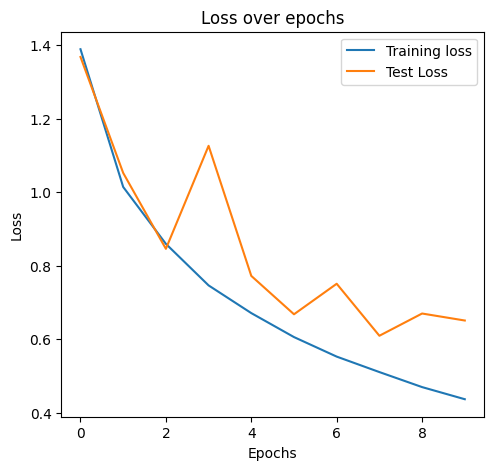

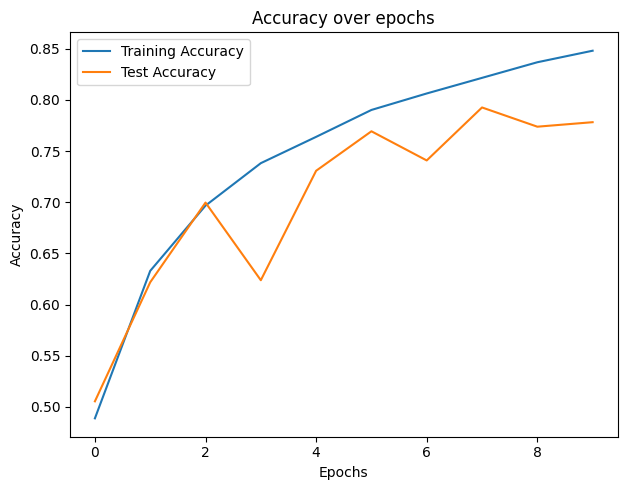

In [6]:
#Step4: Plot the Training and Validation Loss and Accuracy
#Plotting the training and test loss
plt.figure(figsize =(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#plotting the training and test accuracy
plt.figure(figsize = (12,5))
plt.subplot(1,2,2)
plt.plot(train_accuracies, label = 'Training Accuracy')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

3. Find your own dataset which contains at least 3 classes. If you download from 
somewhere, please reference in your report. Make your own dataset class, explain how to 
setup your data and the label. Train the dataset in ResNet and InceptionResNet, show 
your results. (30 points) 

In [5]:
#RESNET
import os
import shutil
import random

#  Use relative path since I'm  already inside /Lab05/Question3lab; It means I have already ".ipynb" file inside the Folder Question3Lab and I have datas there.
data_dir = 'dataset'  
output_dir = 'SplitData'  

# Create train/test directories
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

# Define split ratio
split_ratio = 0.8  # 80% train, 20% test

# Split each class folder
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    random.shuffle(images)
    split_point = int(len(images) * split_ratio)
    train_imgs = images[:split_point]
    test_imgs = images[split_point:]
    
    # Make subfolders for each class in train/test
    os.makedirs(os.path.join(output_dir, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test', cls), exist_ok=True)

    # Copy images
    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(output_dir, 'train', cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(output_dir, 'test', cls, img))

print("Dataset successfully split into train/test folders!")


Dataset successfully split into train/test folders!


In [13]:
import os
import shutil

# Walk through the entire dataset directory and delete any ".ipynb_checkpoints" folders
for root, dirs, files in os.walk('SplitData'):
    for d in dirs:
        if d == '.ipynb_checkpoints':
            dir_path = os.path.join(root, d)
            shutil.rmtree(dir_path)
            print(f" Removed: {dir_path}")

print("All .ipynb_checkpoints folders cleaned successfully!")


 Removed: SplitData/train/.ipynb_checkpoints
 Removed: SplitData/test/.ipynb_checkpoints
All .ipynb_checkpoints folders cleaned successfully!


In [46]:
#2. Creating custom Dataset Class and Loading Data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Defining transformations(resize, normalize, augmentations)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# Load train and test datasets using ImageFolder
train_data = datasets.ImageFolder(root='SplitData/train', transform=transform)
test_data = datasets.ImageFolder(root='SplitData/test', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Check class names
print("Classes:", train_data.classes)
print(f"Total training images: {len(train_data)}, Test images: {len(test_data)}")

Classes: ['cars', 'planes', 'trains']
Total training images: 960, Test images: 240


In [47]:
# Step 3: Defining and Prepare ResNet Model
import torch
import torch.nn as nn
from torchvision import models

num_classes = len(train_data.classes)

# Load pretrained ResNet18
resnet_model = models.resnet18(pretrained=True)

# Replace the final layer (fully connected)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

print(resnet_model)


/home/jupyter-125993/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-125993/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
# Step 4: Train the ResNet Model and Record Metrics (Train + Validation)

import torch
import torch.nn as nn
import torch.optim as optim

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

num_epochs = 10

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    #TRAINING PHASE 
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # VALIDATION PHASE
    resnet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:  # test_loader acts as validation set
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(test_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("Training and validation complete!")


Epoch [1/10] Train Loss: 0.1741, Train Acc: 93.02% | Val Loss: 0.6523, Val Acc: 90.42%
Epoch [2/10] Train Loss: 0.0948, Train Acc: 97.40% | Val Loss: 0.0655, Val Acc: 97.50%
Epoch [3/10] Train Loss: 0.0214, Train Acc: 99.27% | Val Loss: 0.0230, Val Acc: 99.58%
Epoch [4/10] Train Loss: 0.0026, Train Acc: 100.00% | Val Loss: 0.0132, Val Acc: 99.58%
Epoch [5/10] Train Loss: 0.0051, Train Acc: 99.90% | Val Loss: 0.0679, Val Acc: 97.50%
Epoch [6/10] Train Loss: 0.0295, Train Acc: 98.96% | Val Loss: 0.4094, Val Acc: 87.92%
Epoch [7/10] Train Loss: 0.0579, Train Acc: 97.81% | Val Loss: 0.1880, Val Acc: 95.00%
Epoch [8/10] Train Loss: 0.0862, Train Acc: 97.50% | Val Loss: 0.0973, Val Acc: 97.08%
Epoch [9/10] Train Loss: 0.0340, Train Acc: 98.96% | Val Loss: 0.0811, Val Acc: 96.25%
Epoch [10/10] Train Loss: 0.0694, Train Acc: 98.44% | Val Loss: 0.7187, Val Acc: 87.92%
Training and validation complete!


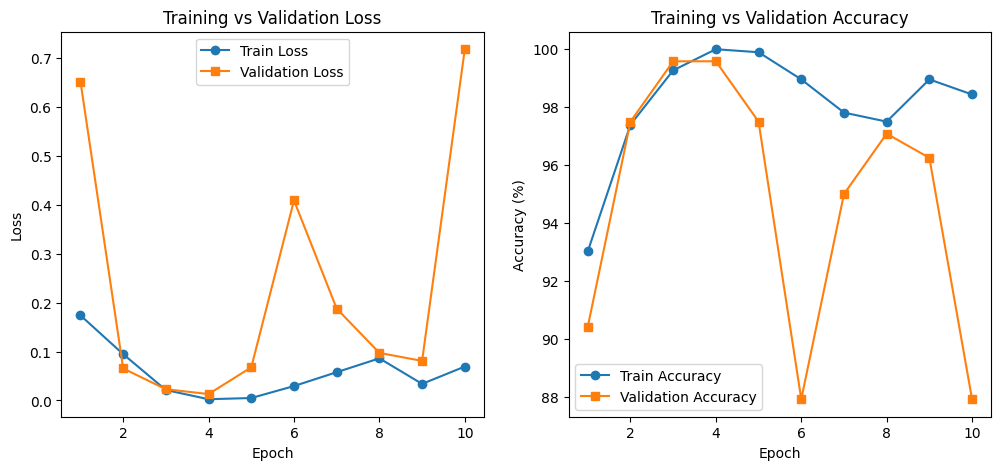

In [50]:
#5. Plotting the results
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,5))

# Plotting Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy 
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


Conclusion: The model achieves near-perfect accuracy on the training set very quickly, indicating it has learned the training data extremely well. However, the validation accuracy drops and validation loss rises after a few epochs, showing clear signs of overfitting and limited generalization to unseen data

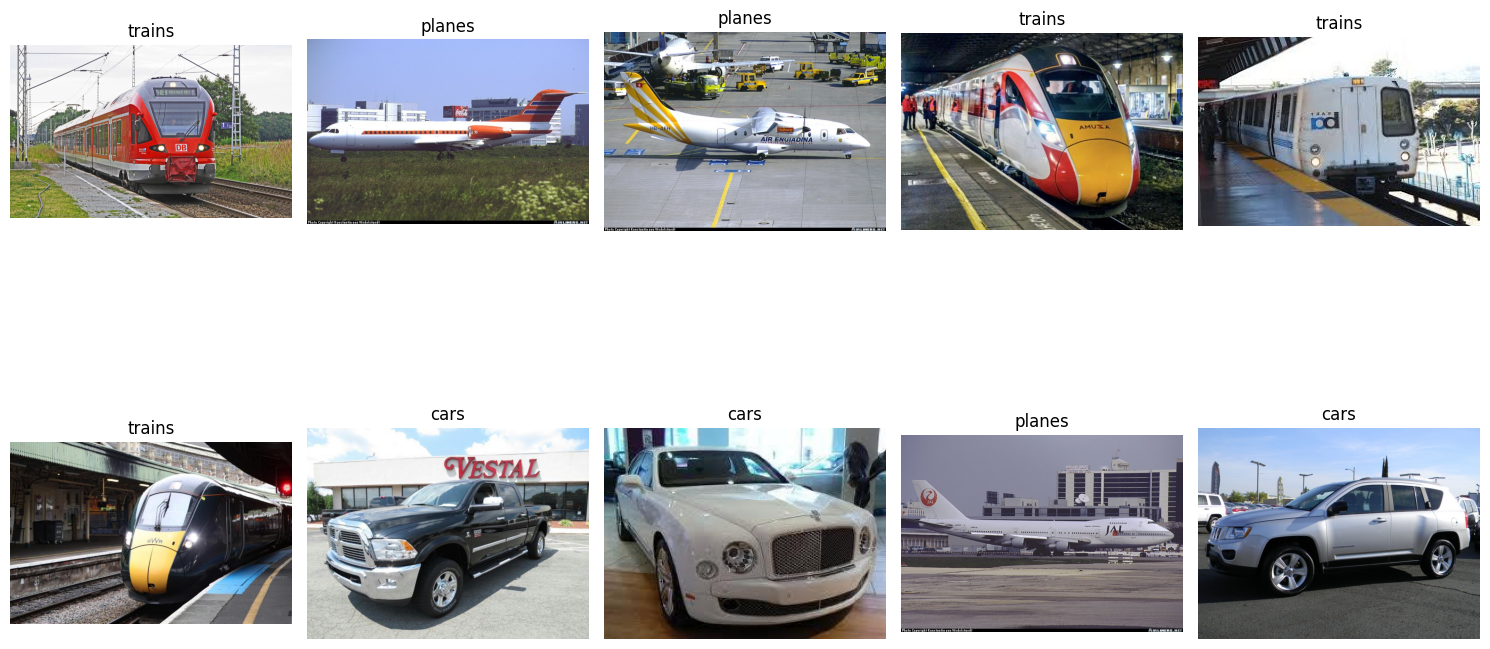

In [20]:
#  Show Sample Images from the Training Dataset 
import random
from PIL import Image
import matplotlib.pyplot as plt

# Get 10 random images from the training dataset
sample_images = random.sample(train_data.imgs, 10)

# Plot the sample images
plt.figure(figsize=(15, 10))
for i, (img_path, label) in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(train_data.classes[label])  # Display the class name
    plt.axis('off')

plt.tight_layout()
plt.show()


TRAINING ON THE INCEPTIONRESNET MODEL

In [42]:
# Step 6: Train InceptionResNetV2 Model with Mixed Precision (Memory Efficient)

import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.cuda.amp import autocast, GradScaler
import subprocess

#  GPU Auto-Selection 
def get_free_gpu():
    try:
        result = subprocess.check_output(
            ['nvidia-smi', '--query-gpu=memory.free', '--format=csv,nounits,noheader']
        )
        memory_free = [int(x) for x in result.decode('utf-8').strip().split('\n')]
        return memory_free.index(max(memory_free))
    except:
        return 0

device = torch.device(f'cuda:{get_free_gpu()}' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load Model 
inception_model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=num_classes)
inception_model = inception_model.to(device)

# Freeze All Layers Except Classifier 
for param in inception_model.parameters():
    param.requires_grad = False


in_features = inception_model.get_classifier().in_features
inception_model.classifier = nn.Linear(in_features, num_classes).to(device)


for param in inception_model.classifier.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_model.classifier.parameters(), lr=0.001)
scaler = GradScaler()

#  Training Setup 
num_epochs = 10

# Lists to store metrics per epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training Loop 
for epoch in range(num_epochs):
    torch.cuda.empty_cache()  # free memory at start of epoch

    # ---------- TRAINING ----------
    inception_model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images = torch.nn.functional.interpolate(images, size=(299, 299),
                                                 mode='bilinear', align_corners=False)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = inception_model(images)
            loss = criterion(outputs, labels)

        if loss.requires_grad:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    #  VALIDATION 
    inception_model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = torch.nn.functional.interpolate(images, size=(299, 299),
                                                     mode='bilinear', align_corners=False)
            images, labels = images.to(device), labels.to(device)
            outputs = inception_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("Training and validation complete!")


Using device: cuda:2


/tmp/ipykernel_1017700/1091387891.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_1017700/1091387891.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/10] Train Loss: 1.1250, Train Acc: 34.06% | Val Loss: 1.1376, Val Acc: 32.92%
Epoch [2/10] Train Loss: 1.1251, Train Acc: 33.85% | Val Loss: 1.1378, Val Acc: 33.75%
Epoch [3/10] Train Loss: 1.1255, Train Acc: 33.85% | Val Loss: 1.1369, Val Acc: 33.75%
Epoch [4/10] Train Loss: 1.1247, Train Acc: 34.38% | Val Loss: 1.1332, Val Acc: 33.75%
Epoch [5/10] Train Loss: 1.1259, Train Acc: 34.06% | Val Loss: 1.1361, Val Acc: 33.75%
Epoch [6/10] Train Loss: 1.1247, Train Acc: 34.27% | Val Loss: 1.1358, Val Acc: 33.75%
Epoch [7/10] Train Loss: 1.1245, Train Acc: 33.65% | Val Loss: 1.1358, Val Acc: 33.75%
Epoch [8/10] Train Loss: 1.1242, Train Acc: 33.96% | Val Loss: 1.1367, Val Acc: 33.75%
Epoch [9/10] Train Loss: 1.1255, Train Acc: 34.27% | Val Loss: 1.1352, Val Acc: 33.75%
Epoch [10/10] Train Loss: 1.1274, Train Acc: 33.96% | Val Loss: 1.1365, Val Acc: 33.75%
Training and validation complete!


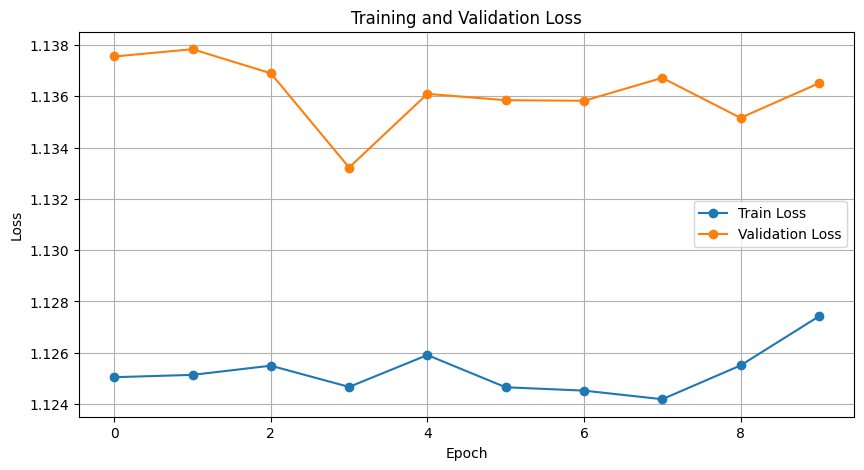

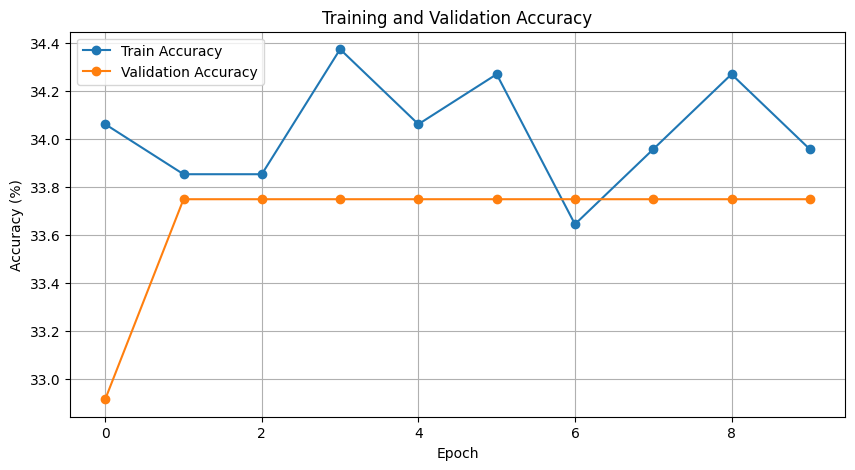

In [44]:
import matplotlib.pyplot as plt

#Plot Training and Validation Loss 
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#Plot Training and Validation Accuracy
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


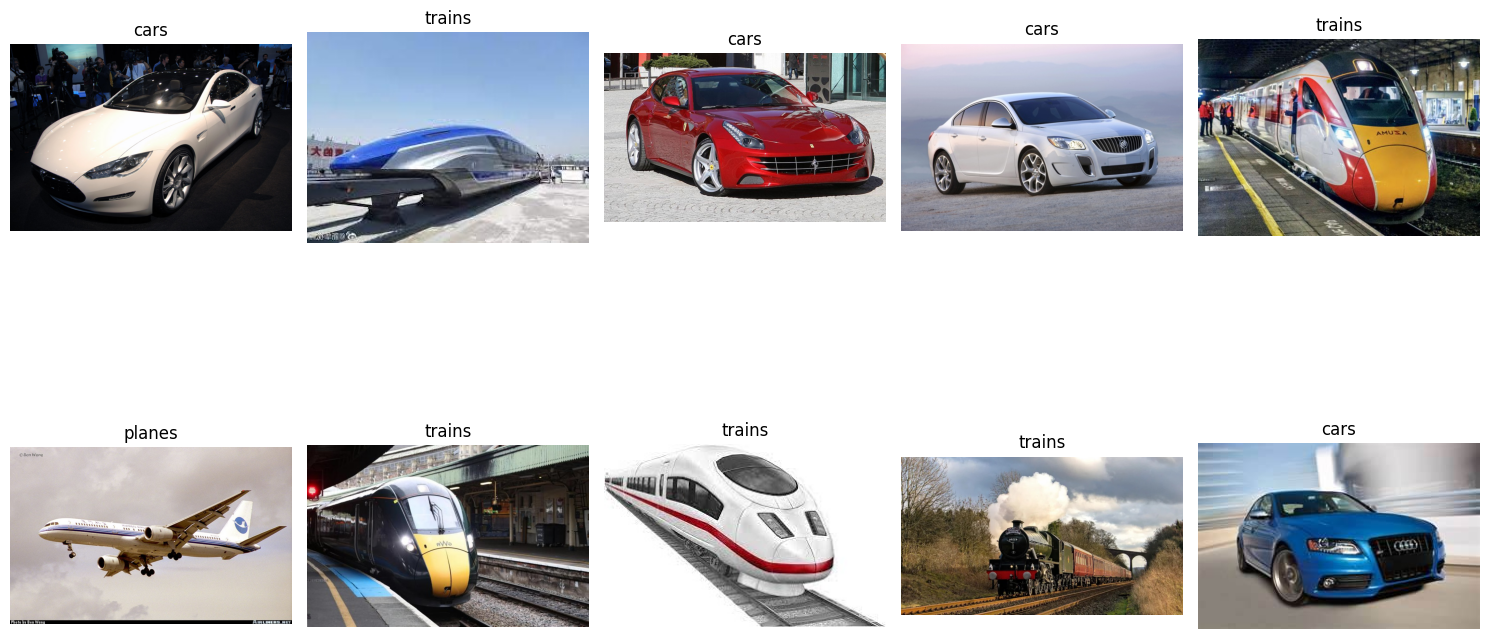

In [45]:
#Show Sample Images from the Training Dataset 
import random
from PIL import Image
import matplotlib.pyplot as plt

# Get 10 random images from the training dataset
sample_images = random.sample(train_data.imgs, 10)

# Plot the sample images
plt.figure(figsize=(15, 10))
for i, (img_path, label) in enumerate(sample_images):
    img = Image.open(img_path).convert("RGB")  # Ensure 3-channel
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(train_data.classes[label])  # Display the class name
    plt.axis('off')

plt.tight_layout()
plt.show()


CONCLUSION: The ResNet model quickly learns the training data, achieving near-perfect training accuracy and high validation accuracy in the first few epochs, though it shows some overfitting later. In contrast, the InceptionResNetV2 model fails to learn effectively, with training and validation accuracy stagnating around 34% and high, almost constant loss, indicating poor convergence. Overall, ResNet significantly outperforms InceptionResNetV2 on this dataset, suggesting it is better suited or better configured for this task.


The link for the dataset is: https://www.kaggle.com/datasets/maciejgronczynski/vehicle-classification-dataset?resource=download